## General Equilibrium: The Aiyagari Model with endogenous labor supply

This code solves for the market clearing interest rate in the Aiyagari model. It uses the EGM routines for the policy functions and Young's method for the distribution, as well as a bisection procedure to obtain the interest rate.

policy function iteration successful!
  4.851592 seconds (9.19 M allocations: 580.253 MiB, 9.88% gc time)
policy function iteration successful!


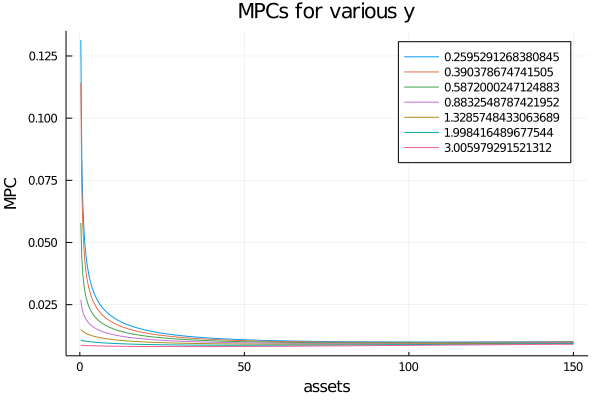

In [1]:
#this notebook solves for the general equilibrium of the Aiyagari model using EGM with endogenous labor supply

using NBInclude

@nbinclude("EGM_labor.ipynb") # include EGM functions (make sure it is in your working directory)

In [2]:
Household = @with_kw (apoints = 500, #asset grid
    amax = 150,  # asset max
    beta = 0.986, # discount factor
    alpha = 0.11, # capital share
    deprec = 0.025, # depreciation rate
    gamma = 2.0, # inverse elasticity of substitution
    bc = 0, # borrowing constraint (must be weakly negative)
    rho = 0.966,  # autocorr of income process
    uncond_sd = 0.5, # unconditional sd
    num_states = 7, # number of states for income process
    sd = sqrt(1-rho^2)*uncond_sd, # stand. dev. of deviation process
    mean = 0, # mean of income process
    transition_matrix = rowenhorst(mean, uncond_sd, rho, num_states)[1], # transition matrix
    ygrid = rowenhorst(mean, uncond_sd, rho, num_states)[2], # grid for income process
    Amat = setgrids(bc, apoints, amax, num_states, ygrid)[1], # asset grid
    Ymat = setgrids(bc, apoints, amax, num_states, ygrid)[2], # income grid
    phi = 0.8, # disutility factor
    frisch = 2.0) # inverse frisch elasticity for labor supply 

hh = Household()

(apoints = 500, amax = 150, beta = 0.986, alpha = 0.11, deprec = 0.025, gamma = 2.0, bc = 0, rho = 0.966, uncond_sd = 0.5, num_states = 7, sd = 0.12927103310486848, mean = 0, transition_matrix = [0.9022379843199956 0.09361981119088468 … 8.374316586000039e-9 2.4137569000000128e-11; 0.015603301865147443 0.9035872016735433 … 4.0355125541400147e-7 1.3957194310000061e-9; … ; 1.3957194310000061e-9 4.0355125541400147e-7 … 0.9035872016735433 0.015603301865147443; 2.4137569000000125e-11 8.374316586000037e-9 … 0.09361981119088467 0.9022379843199955], ygrid = [0.2595291268380845, 0.390378674741505, 0.5872000247124883, 0.8832548787421952, 1.3285748433063689, 1.998416489677544, 3.005979291521312], Amat = [0.0 0.0 … 0.0 0.0; 0.30060120240480964 0.30060120240480964 … 0.30060120240480964 0.30060120240480964; … ; 149.6993987975952 149.6993987975952 … 149.6993987975952 149.6993987975952; 150.0 150.0 … 150.0 150.0], Ymat = [0.2595291268380845 0.390378674741505 … 1.998416489677544 3.005979291521312; 0.259

In [3]:
iterate_egm(hh, r = 0.005) # making sure everything works

policy function iteration successful!


([0.35229752118305996 0.47850289789110645 … 1.2148663346638955 1.4190262982915134; 0.39317426214311746 0.5150687254011402 … 1.2184949655723785 1.4218379738960796; … ; 2.26736827882482 2.296861404683529 … 2.5227941054792624 2.6324619387779262; 2.2700978155416736 2.2995595733464 … 2.5252834594903275 2.6348697284067164], [0.0 -5.551115123125783e-17 … 0.9680672666452592 2.0286663981941464; 0.22460051625255828 0.23156843949032035 … 1.2600421522667495 2.321141140495313; … ; 148.23526654416796 148.25072042926305 … 148.97630619672066 149.67390957572943; 148.53457539835333 148.55000950324722 … 149.27488480303504 149.97190768718832], [1.5252234547400059 1.3772363612116718 … 1.2273389436899589 1.2887021641997722; 1.366652128820109 1.2794634141444783 … 1.2236839757564917 1.2861537638172; … ; 0.23698507532868335 0.2869183088613868 … 0.5910322846689933 0.6946737708631818; 0.23670012749074115 0.28658165570451855 … 0.5904496615250526 0.6940389659303823])

In [4]:
function get_kernel(hh; policyfun)
    
"""
    get transition kernel for asset-income distribution using Young's method
    
    #### Fields
    
    - 'hh': household tuple
    - 'policyfun': savings function, array na x ny
    
    #### Returns
    
    - 'kernel': na*ny x na*ny array row-stochastic transition kernel
    
"""

@unpack apoints, Amat, num_states, Ymat, transition_matrix = hh
    
# construct transition matrix without labour stochasticity
Q = zeros(apoints, apoints, num_states)
    
# find which element to interpolate to
findnearest(A,t) = findmin(abs.(A.-t))[2]

# construct matrices to get neighboring indices
next = similar(Amat)
previous = similar(Amat)

for j = 1:num_states
    for k = 1:apoints
        ind = findnearest(Amat[:,j],policyfun[k,j])
            if policyfun[k,j] - Amat[ind,j] > 0
                previous[k,j] = Amat[ind,j]
                if ind == apoints
                    next[k,j] = Amat[ind,j]
                else         
                next[k,j] = Amat[ind+1,j]
                end
            elseif policyfun[k,j] == Amat[ind,j]
                previous[k,j] = policyfun[k,j] 
                next[k,j] = policyfun[k,]
            else
                next[k,j] = Amat[ind,j]
                if ind == 1
                    previous[k,j] = Amat[ind,j]
                else
                    previous[k,j] = Amat[ind-1,j]
                end
            end  
    end
end
    
# construct transition matrix for assets.
# Q[i,j,k] is the probability of going to agrid[i] when current assets are agrid[j] and income is ygrid[k]
for k = 1:apoints
    for j = 1:num_states
        if next[k,j] == previous[k,j]
            Q[Amat[:,1].==previous[k,j],k,j] .= 1
        else
            Q[Amat[:,1].==previous[k,j],k,j] .= (next[k,j]-policyfun[k,j])./(next[k,j]-previous[k,j])
            Q[Amat[:,1].==next[k,j],k,j] .= 1 - (next[k,j]-policyfun[k,j])./(next[k,j]-previous[k,j])  
        end
    end
end
    
# construct transition kernel by taking the kronecker product of assets and transition_matrix for income
kernel = zeros(apoints*num_states,apoints*num_states)

for j=1:num_states
    for i=1:num_states
        kernel[(i-1)*apoints+1:i*apoints,(j-1)*apoints+1:j*apoints]=Q[:,:,j].*transition_matrix[j,i];
    end
end

kernel = kernel'
    
return kernel
end

get_kernel (generic function with 1 method)

In [5]:
function histogram_method(hh; kernel, tol=1e-8, maxiter=10000)
    #needs Markov transition kernel
    @unpack apoints, num_states = hh
    
    #initial guess for invariant distribution
    init = ones(apoints*num_states)
    init = init./sum(init)
    
    dist = 1
    counter = 0
    
    for i=1:maxiter
        initnext = (init'*kernel)'
        if norm(init-initnext,Inf) < tol 
            println("distribution iteration successful!")
            return initnext
        else
            init = initnext
        end
    end
    
    error("distribution did not convergence!")
end

histogram_method (generic function with 1 method)

In [6]:
function ss(hh; r)
    @unpack beta, Ymat = hh
    @assert r < 1/(beta)-1 "r too large for convergence"
    
    c, anext, l = iterate_egm(hh; r = r) # get converged policy function
    kernel = get_kernel(hh; policyfun = anext) # get kernel
    
    invariant_distribution = histogram_method(hh; kernel = kernel) # get invariant distribution
    
    K = getagg(; policyfun = anext, dist = invariant_distribution) # get aggregate capital
    L = getagg(; policyfun = l.*Ymat, dist = invariant_distribution) # get aggregate labor
    return K/L
end

ss (generic function with 1 method)

In [7]:
function plot_market_clearing(hh)
    
    @unpack alpha, deprec = hh
    
    rgrid =  -0.004:0.002:0.009
    Ksupply = zeros(length(rgrid))
    
    for (index,r) in enumerate(rgrid)
        Ksupply[index] = ss(hh; r=r)
    end
    
    plot(rgrid, Ksupply, label = "capital supply per capita")
    
    Z(r) = ((r + deprec)/alpha)^alpha # normalize so Y=1
    K(r) = ((Z(r)*alpha)/(r+deprec))^(1/(1-alpha))
    
    plot!(rgrid,K.(rgrid), label= "capital demand per capita")
    xlabel!("r-δ")
    ylabel!("capital")
    
end

plot_market_clearing (generic function with 1 method)

policy function iteration successful!
distribution iteration successful!
policy function iteration successful!
distribution iteration successful!
policy function iteration successful!
distribution iteration successful!
policy function iteration successful!
distribution iteration successful!
policy function iteration successful!
distribution iteration successful!
policy function iteration successful!
distribution iteration successful!
policy function iteration successful!
distribution iteration successful!


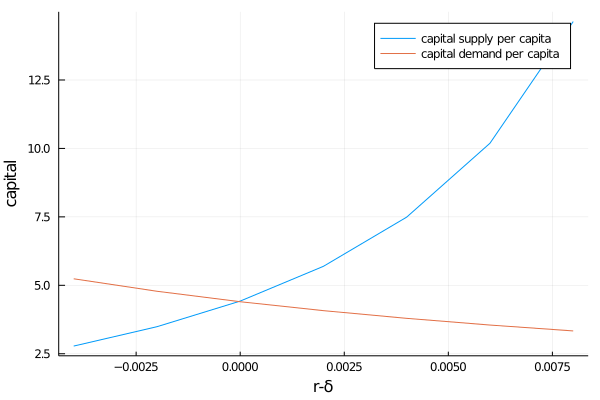

In [8]:
plot_market_clearing(hh)

In [9]:
function market_clearing(hh; r = 0.0, tol = 1e-5, maxiter = 20, bisection_param = 0.8)
    @unpack alpha, deprec = hh
    
    for iter = 1:maxiter
        print("r=$r: ")
        Ksupply = ss(hh; r=r)
    
        Z = ((r + deprec)/alpha)^alpha
        rsupply = Z*alpha*(1/Ksupply)^(1-alpha) - deprec
        
        if abs(r-rsupply) < tol
            return (r+rsupply)/2
        else r = (bisection_param)*r + (1-bisection_param)*rsupply
        end
    end
    
    error("no convergence: did not find market clearing real rate")
end

market_clearing (generic function with 1 method)

In [10]:
@time market_clearing(hh)

r=0.0: policy function iteration successful!
distribution iteration successful!
r=-2.434583621548011e-5: policy function iteration successful!
distribution iteration successful!
r=-3.1198356390108175e-5: policy function iteration successful!
distribution iteration successful!
 17.850539 seconds (512.28 k allocations: 1.939 GiB, 5.80% gc time)


-3.600981083796112e-5